In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.circuit import ParameterVector

In [342]:
import warnings
# Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore')

In [15]:
#Load the dataset
import pandas as pd
# Read the text file
with open('Fingerprint_A.txt', 'r') as file:
    lines = file.readlines()
# Split the lines into separate columns based on comma delimiter
data = [line.strip().split(',') for line in lines] 
edge = pd.DataFrame(data, columns=['node1', 'node2'])
#Read the text file
graph_ind = pd.read_csv("Fingerprint_graph_indicator.txt",names=['graph'])
# Read the text file
with open('Fingerprint_node_attributes.txt', 'r') as file:
    lines = file.readlines()
# Split the lines into separate columns based on comma delimiter
data = [line.strip().split(',') for line in lines] 
node_feat = pd.DataFrame(data, columns=['x', 'y'])

In [167]:
#Relabel edges
edge = edge.astype(int)
edge = edge.applymap(lambda x: x + 1)

In [19]:
#Create node_id column for node features and graph indices data set
node_feat['node_id']=node_feat.index
graph_ind['node_id']=graph_ind.index

In [25]:
graph_ind.head(3)

,graph,node_id
0,1,0
1,1,1
2,2,2


In [27]:
# Merge graph_ind and node_feat data frames
combined_df = pd.merge(graph_ind, node_feat, on='node_id')
# Group by graph_id and collect node features for each graph
topology_df = combined_df.groupby('graph').apply(lambda x: sorted(list(zip(x['node_id'], x[['x', 'y']].values)))).reset_index(name='topology')
topology_df.head(3)

,graph,topology
0,1,"[(0, [124.0, 121.0]), (1, [119.0, 143.0])]"
1,2,"[(2, [125.0, 130.0]), (3, [33.0, 155.0]), (4..."
2,3,"[(14, [124.0, 121.0]), (15, [119.0, 143.0])]"


In [205]:
import numpy as np
# Function to generate adjacency matrix for a given topology
def generate_adjacency_matrix(topology):
    num_nodes = len(topology[0])
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(num_nodes):
        start_node_id, start_node_feat = topology[0][i][0], list(topology[0][i][1])
        for j in range(i+1, num_nodes):
            end_node_id, end_node_feat = topology[0][j][0], list(topology[0][j][1])
            if (start_node_id,end_node_id) in edge.values or (end_node_id, start_node_id) in edge.values:
                adj_matrix[i][j] = adj_matrix[j][i] = 1
    return adj_matrix

In [250]:
#There are too many graphs, so sample a subset.
sampled_topology_df = topology_df[['topology']].sample(frac=0.5).reset_index(drop=True)  # Adjust the fraction as needed

In [251]:
sampled_topology_df.head(3)

,topology
0,"[(13139, [128.0, 99.0]), (13140, [98.0, 141...."
1,"[(11636, [138.0, 81.0]), (11637, [146.0, 106..."
2,"[(4258, [146.0, 137.0]), (4259, [201.0, 182...."


In [252]:
#Want to add adjacency matrices for each of the graph topology
sampled_topology_df['adj']=sampled_topology_df[['topology']].apply(generate_adjacency_matrix, axis=1)

In [253]:
sampled_topology_df.head(3)

,topology,adj
0,"[(13139, [128.0, 99.0]), (13140, [98.0, 141....","[[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1,..."
1,"[(11636, [138.0, 81.0]), (11637, [146.0, 106...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]..."
2,"[(4258, [146.0, 137.0]), (4259, [201.0, 182....","[[0, 1, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1], [1, 1..."


In [343]:
#Focus on 2x2 matrices
sampled_topology_df_filtered_2b2 = sampled_topology_df[sampled_topology_df['adj'].apply(lambda x: len(x) == 2)]
# Get the two most frequent topologies
sampled_topology_df_filtered_2b2['adj_tuple'] = sampled_topology_df_filtered_2b2['adj'].apply(lambda x: tuple(map(tuple, x)))
top2_freq_topologies_2b2 = sampled_topology_df_filtered_2b2['adj_tuple'].value_counts().nlargest(2).index.tolist()

In [255]:
sampled_topology_df_filtered_2b2.head(3)

,topology,adj,adj_tuple
3,"[(10654, [173.0, 171.0]), (10655, [168.0, 18...","[[0, 1], [1, 0]]","((0, 1), (1, 0))"
7,"[(8323, [120.0, 133.0]), (8324, [111.0, 146....","[[0, 1], [1, 0]]","((0, 1), (1, 0))"
13,"[(9399, [128.0, 123.0]), (9400, [138.0, 144....","[[0, 1], [1, 0]]","((0, 1), (1, 0))"


In [256]:
top2_freq_topologies_2b2

[((0, 1), (1, 0)), ((0, 0), (0, 0))]

In [344]:
#Focus on 2x2 matrices
sampled_topology_df_filtered_3b3 = sampled_topology_df[sampled_topology_df['adj'].apply(lambda x: len(x) == 3)]
# Get the two most frequent topologies
sampled_topology_df_filtered_3b3['adj_tuple'] = sampled_topology_df_filtered_3b3['adj'].apply(lambda x: tuple(map(tuple, x)))
top2_freq_topologies_3b3 = sampled_topology_df_filtered_3b3['adj_tuple'].value_counts().nlargest(2).index.tolist()
sampled_topology_df_filtered_3b3.head(3)

,topology,adj,adj_tuple
12,"[(10743, [149.0, 151.0]), (10744, [179.0, 18...","[[0, 1, 1], [1, 0, 1], [1, 1, 0]]","((0, 1, 1), (1, 0, 1), (1, 1, 0))"
15,"[(12634, [133.0, 135.0]), (12635, [144.0, 16...","[[0, 1, 1], [1, 0, 1], [1, 1, 0]]","((0, 1, 1), (1, 0, 1), (1, 1, 0))"
36,"[(6585, [130.0, 130.0]), (6586, [147.0, 153....","[[0, 1, 1], [1, 0, 1], [1, 1, 0]]","((0, 1, 1), (1, 0, 1), (1, 1, 0))"


In [258]:
top2_freq_topologies_3b3

[((0, 1, 1), (1, 0, 1), (1, 1, 0))]

In [345]:
#Focus on 4x4 matrices
sampled_topology_df_filtered_4b4 = sampled_topology_df[sampled_topology_df['adj'].apply(lambda x: len(x) == 4)]
# Get the two most frequent topologies
sampled_topology_df_filtered_4b4['adj_tuple'] = sampled_topology_df_filtered_4b4['adj'].apply(lambda x: tuple(map(tuple, x)))
top2_freq_topologies_4b4 = sampled_topology_df_filtered_4b4['adj_tuple'].value_counts().nlargest(2).index.tolist()
sampled_topology_df_filtered_4b4.head(3)

,topology,adj,adj_tuple
0,"[(13139, [128.0, 99.0]), (13140, [98.0, 141....","[[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1,...","((0, 1, 1, 1), (1, 0, 1, 1), (1, 1, 0, 1), (1,..."
10,"[(14380, [148.0, 98.0]), (14381, [145.0, 168...","[[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1,...","((0, 1, 1, 1), (1, 0, 1, 1), (1, 1, 0, 1), (1,..."
17,"[(3274, [144.0, 110.0]), (3275, [142.0, 171....","[[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1,...","((0, 1, 1, 1), (1, 0, 1, 1), (1, 1, 0, 1), (1,..."


In [268]:
top2_freq_topologies_4b4

[((0, 1, 1, 1), (1, 0, 1, 1), (1, 1, 0, 1), (1, 1, 1, 0))]

In [ ]:
top_2d=sampled_topology_df_filtered_2b2[['topology']]
top_3d=sampled_topology_df_filtered_3b3[['topology']]
top_4d=sampled_topology_df_filtered_4b4[['topology']]

In [269]:
top_2d.head(2)

,topology
3,"[(10654, [173.0, 171.0]), (10655, [168.0, 18..."
7,"[(8323, [120.0, 133.0]), (8324, [111.0, 146...."


In [335]:
#Now starts QC part. For different dimensions, 
#Modify A(Line3), n_samples(Line11), Xs(Line23, 24)
A=[[0,0],[0,0]]
#A=[[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]]
# Create a quantum circuit with Nv qubits
import pennylane as qml
from qiskit.circuit import Parameter
#Number of nodes
Nv = len(A)
#Number of training samples
n_samples=len(sampled_topology_df_filtered_2b2)
#Number of features
n_features=2
#Number of qubits
num_qubits = Nv * n_features  
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = np.random.random(size=(num_params))
#Extract 2d features from 'topology' column
def extract_features(row):
    feature_vectors = [feat for _, feat in row[0]]
    return np.array(feature_vectors)
# Apply the function to each row of the DataFrame and convert the result into a numpy array
Xs = np.array(top_2d.apply(extract_features, axis=1).tolist())
Xs = Xs.reshape(Xs.shape[0], -1).astype(float)

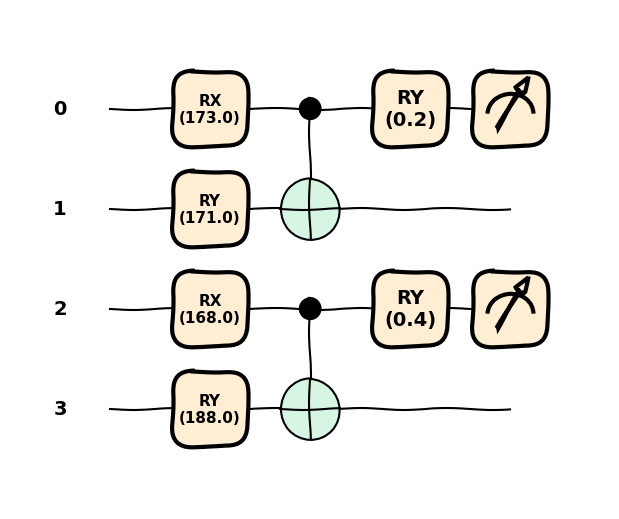

In [336]:
import matplotlib.pyplot as plt
#For QC display
def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(n_features):
                if j==0:
                    qml.RX(X[i*n_features+j], wires = i * n_features + j)
                elif j==1:
                    qml.RY(X[i*n_features+j], wires = i * n_features + j)
            #Entangle 2 features
            qml.CNOT(wires = [i * n_features, i *n_features + 1])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * n_features)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    qml.CNOT(wires = [i * n_features, j * n_features])
        if Nv==2:
            return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(n_features))
        elif Nv==3:
            return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(n_features)),qml.sample(qml.PauliZ(2*n_features))
        else:
            return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(n_features)),qml.sample(qml.PauliZ(2*n_features)),qml.sample(qml.PauliZ(3*n_features))

dev = qml.device("default.qubit", wires=n_features*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(Xs[0],ansatz)
plt.show()

In [337]:
# Initialize a measurement quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*n_features, shots=100)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(n_features):
                if j==0:
                    qml.RX(X[i*n_features+j], wires = i * n_features + j)
                elif j==1:
                    qml.RY(X[i*n_features+j], wires = i * n_features + j)
        #Entangle 2 features
        qml.CNOT(wires = [i * n_features, i * n_features + 1])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * n_features)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * n_features, j * n_features])
        if Nv==2:
            return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(n_features))
        elif Nv==3:
            return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(n_features)),qml.sample(qml.PauliZ(2*n_features))
        else:
            return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(n_features)),qml.sample(qml.PauliZ(2*n_features)),qml.sample(qml.PauliZ(3*n_features))

    x = quantum_circuit(X, ansatz)
    y = [[x[j][i] for j in range(Nv)] for i in range(len(x[0]))]
    return y

In [338]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*n_features, shots=100)
@qml.qnode(dev)
def measure(X,ansatz):
    x = quantum_circuit(X, ansatz)
    return x
def transform(x):
    y = [[x[j][i] for j in range(Nv)] for i in range(100)]
    return y
def minus_to_zero(y):
    for j in range(len(y)):
        for i in range(Nv):
            if y[j][i]<0:
                y[j][i]=0
    return y
X=Xs[0]
result=minus_to_zero(transform(measure(X,ansatz)))

In [339]:
#Collect measurement results from 100 samples
results=[]
for X in Xs:
    result=minus_to_zero(transform(measure(X,ansatz)))
    results.extend(result)

In [340]:
#Plotting tool
def plot_result(measurements,tf):
    # Convert each sublist in y to a binary string and create a list of binary strings
    binary_strings = [''.join(map(str, sublist)) for sublist in result]
    unique_binary_strings, counts = np.unique(binary_strings, return_counts=True)
    # Plotting the histogram
    plt.bar(unique_binary_strings, counts, edgecolor='black')
    # Adding labels and title
    plt.xlabel('Results')
    plt.ylabel('Frequency')
    if tf=='T':
        plt.title(str(n_features)+'-qubits measurement for true '
                  +str(n_features)+'-nodes graph')
    else:
        plt.title(str(n_features)+'-qubits measurement for fake '
                  +str(n_features)+'-nodes graph')
    # Display the plot
    plt.show()

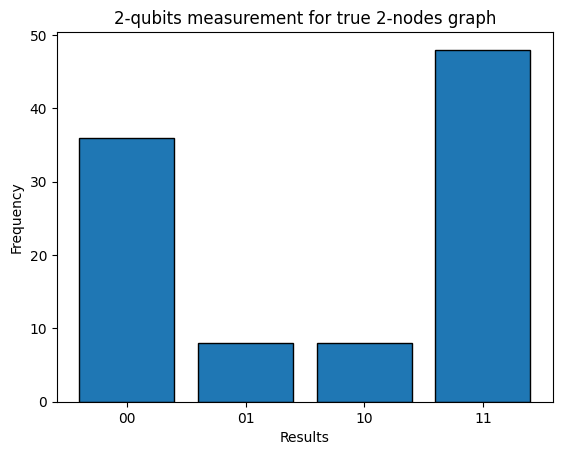

In [299]:
#Show results for the 2-node.
plot_result(results,'T')

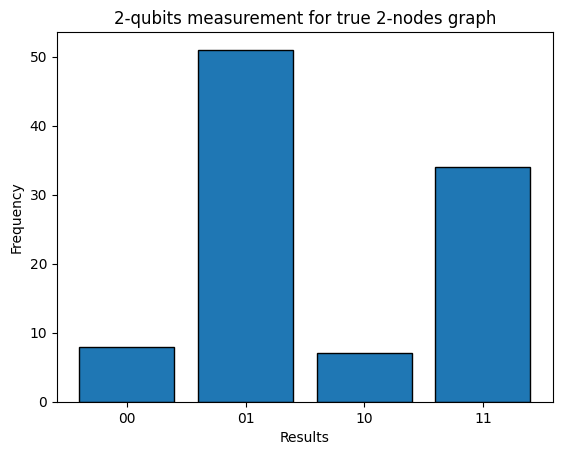

In [341]:
#Show results for the 2-node with A=[[0,0],[0,0]].
plot_result(results,'T')

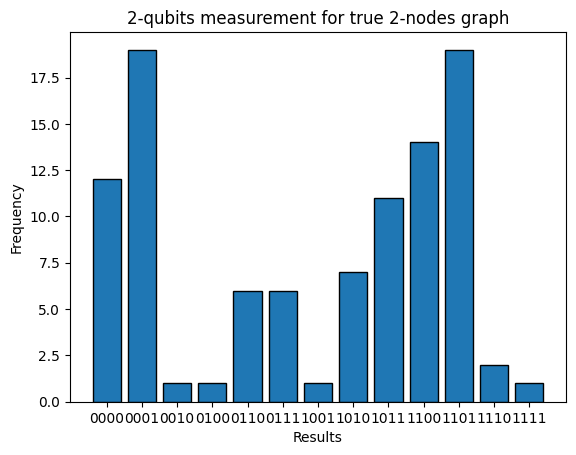

In [334]:
#Show results for the 4-nodes.
plot_result(results,'T')